In [35]:
#import main processing libraries
import pandas as pd
import numpy as np

#import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz

#import stats for statistical analysis
import scipy.stats as stats

#import my own functions for data acquisition and preparation
from acquire import get_telco_data
from prep import prep_telco
from env import get_db_url

# import warnings filter to ignore pesky warnings
import warnings
warnings.filterwarnings('ignore')


### Initial acquisition and exploration

In [3]:
telco_df = get_telco_data()

telco_df.info()

Reading from CSV file...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 27 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   customer_id                 7043 non-null   object 
 1   gender                      7043 non-null   object 
 2   senior_citizen              7043 non-null   int64  
 3   partner                     7043 non-null   object 
 4   dependents                  7043 non-null   object 
 5   tenure                      7043 non-null   int64  
 6   phone_service               7043 non-null   object 
 7   multiple_lines              7043 non-null   object 
 8   internet_service_type_id    7043 non-null   int64  
 9   online_security             7043 non-null   object 
 10  online_backup               7043 non-null   object 
 11  device_protection           7043 non-null   object 
 12  tech_support                7043 non-null   object 
 13  streamin

In [7]:
telco_df.describe()

,senior_citizen,tenure,internet_service_type_id,contract_type_id,payment_type_id,monthly_charges,contract_type_id.1,payment_type_id.1,internet_service_type_id.1
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,1.872923,1.690473,2.315633,64.761692,1.690473,2.315633,1.872923
std,0.368612,24.559481,0.737796,0.833755,1.148907,30.090047,0.833755,1.148907,0.737796
min,0.000000,0.000000,1.000000,1.000000,1.000000,18.250000,1.000000,1.000000,1.000000
25%,0.000000,9.000000,1.000000,1.000000,1.000000,35.500000,1.000000,1.000000,1.000000
50%,0.000000,29.000000,2.000000,1.000000,2.000000,70.350000,1.000000,2.000000,2.000000
75%,0.000000,55.000000,2.000000,2.000000,3.000000,89.850000,2.000000,3.000000,2.000000
max,1.000000,72.000000,3.000000,3.000000,4.000000,118.750000,3.000000,4.000000,3.000000


In [10]:
telco_df_clean, telco_train, telco_validate, telco_test = prep_telco(telco_df)
telco_df_clean.describe()

,senior_citizen,tenure,internet_service_type_id,contract_type_id,payment_type_id,monthly_charges,total_charges,gender_Male,partner_Yes,dependents_Yes,phone_service_Yes,multiple_lines_No phone service,multiple_lines_Yes,online_security_No internet service,online_security_Yes,online_backup_No internet service,online_backup_Yes,device_protection_No internet service,device_protection_Yes,tech_support_No internet service,tech_support_Yes,streaming_tv_No internet service,streaming_tv_Yes,streaming_movies_No internet service,streaming_movies_Yes,paperless_billing_Yes,churn_Yes,contract_type_One year,contract_type_Two year,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check,internet_service_type_Fiber optic,internet_service_type_None
count,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.162400,32.421786,1.872582,1.688567,2.315557,64.798208,2283.300441,0.504693,0.482509,0.298493,0.903299,0.096701,0.421928,0.216155,0.286547,0.216155,0.344852,0.216155,0.343857,0.216155,0.290102,0.216155,0.384386,0.216155,0.388367,0.592719,0.265785,0.209329,0.239619,0.216297,0.336320,0.228100,0.440273,0.216155
std,0.368844,24.545260,0.737271,0.832934,1.149523,30.085974,2266.771362,0.500014,0.499729,0.457629,0.295571,0.295571,0.493902,0.411650,0.452180,0.411650,0.475354,0.411650,0.475028,0.411650,0.453842,0.411650,0.486484,0.411650,0.487414,0.491363,0.441782,0.406858,0.426881,0.411748,0.472483,0.419637,0.496455,0.411650
min,0.000000,1.000000,1.000000,1.000000,1.000000,18.250000,18.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,9.000000,1.000000,1.000000,1.000000,35.587500,401.450000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,29.000000,2.000000,1.000000,2.000000,70.350000,1397.475000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,55.000000,2.000000,2.000000,3.000000,89.862500,3794.737500,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
max,1.000000,72.000000,3.000000,3.000000,4.000000,118.750000,8684.800000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [31]:
# Removing categorical variables and assigning continuous variable to new df
telco_numvar = telco_df_clean.select_dtypes(include='number')
telco_numvar = telco_numvar.drop(columns= ['internet_service_type_id', 'contract_type_id', 'payment_type_id'])

# Viewing correlations between churn and other variables
telco_correl = telco_numvar.corr()
telco_s = telco_correl.unstack()
churn_corr = telco_s.churn_Yes.sort_values(ascending=False)
churn_corr

churn_Yes                                1.000000
internet_service_type_Fiber optic        0.307463
payment_type_Electronic check            0.301455
monthly_charges                          0.192858
paperless_billing_Yes                    0.191454
senior_citizen                           0.150541
streaming_tv_Yes                         0.063254
streaming_movies_Yes                     0.060860
multiple_lines_Yes                       0.040033
phone_service_Yes                        0.011691
gender_Male                             -0.008545
multiple_lines_No phone service         -0.011691
device_protection_Yes                   -0.066193
online_backup_Yes                       -0.082307
payment_type_Mailed check               -0.090773
payment_type_Credit card (automatic)    -0.134687
partner_Yes                             -0.149982
dependents_Yes                          -0.163128
tech_support_Yes                        -0.164716
online_security_Yes                     -0.171270


In [30]:
# Identifying variables most highly correlated with churn, threshold set to 0.3
churn_corr[churn_corr.abs() > 0.3]

churn_Yes                            1.000000
internet_service_type_Fiber optic    0.307463
payment_type_Electronic check        0.301455
contract_type_Two year              -0.301552
tenure                              -0.354049
dtype: float64

In [32]:
# sanity checks
print(type(churn_corr))
print(len(churn_corr))
print(len(telco_numvar.columns))

<class 'pandas.core.series.Series'>
31
31


In [33]:
# assigning variable most highly correlated with churn to new df
telco_highcorr = telco_df_clean[['internet_service_type_Fiber optic', 'payment_type_Electronic check', 'churn_Yes', 'contract_type_Two year', 'tenure']]
telco_highcorr.info()
telco_highcorr.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   internet_service_type_Fiber optic  7032 non-null   uint8
 1   payment_type_Electronic check      7032 non-null   uint8
 2   churn_Yes                          7032 non-null   uint8
 3   contract_type_Two year             7032 non-null   uint8
 4   tenure                             7032 non-null   int64
dtypes: int64(1), uint8(4)
memory usage: 137.3 KB


,internet_service_type_Fiber optic,payment_type_Electronic check,churn_Yes,contract_type_Two year,tenure
count,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.440273,0.336320,0.265785,0.239619,32.421786
std,0.496455,0.472483,0.441782,0.426881,24.545260
min,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,9.000000
50%,0.000000,0.000000,0.000000,0.000000,29.000000
75%,1.000000,1.000000,1.000000,0.000000,55.000000
max,1.000000,1.000000,1.000000,1.000000,72.000000


In [36]:
# column renaming
telco_highcorr.rename(columns= {'internet_service_type_Fiber optic': 'fiber', 'payment_type_Electronic check': 'e_check', 'contract_type_Two year': 'two_yr'}, inplace=True)
telco_highcorr.head()

,fiber,e_check,churn_Yes,two_yr,tenure
0,0,0,0,0,9
1,0,0,0,0,9
2,1,1,1,0,4
3,1,1,1,0,13
4,1,0,1,0,3


Correlation strength: 0.3074625906981481
P-value: 7.887445171814853e-154


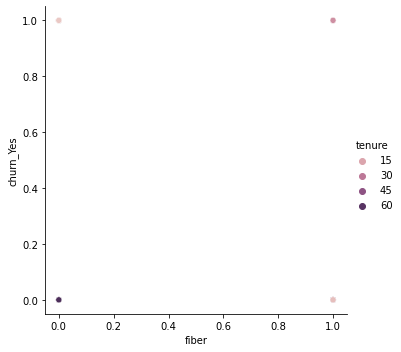

In [37]:
# fiber users and churn
alpha = 0.05
r_coeff, pval = stats.pearsonr(telco_highcorr.fiber, telco_highcorr.churn_Yes)

print(f'Correlation strength: {r_coeff}\nP-value: {pval}')

sns.relplot(data=telco_highcorr, x='fiber', y='churn_Yes', hue='tenure')

In [57]:
# Outputting avg churn and avg use of e-checks 
print(f'Avg churn: {telco_highcorr.churn_Yes.mean():.2%}\nAvg use of e-checks: {telco_highcorr.e_check.mean():.2%}')
print('---------------')
# Setting the dummies equal to each other for comparison
fiber_eq_churn_avg = telco_highcorr[telco_highcorr.churn_Yes == telco_highcorr.fiber].mean()
check_eq_churn_avg = telco_highcorr[telco_highcorr.churn_Yes == telco_highcorr.e_check].mean()
two_yr_eq_churn_avg = telco_highcorr[telco_highcorr.churn_Yes == telco_highcorr.two_yr].mean()


print(f'Fiber and Churn:\n{fiber_eq_churn_avg}\n----------\nE-Check and Churn:\n{check_eq_churn_avg}\n----------\nTwo-yr contract and Churn:\n{two_yr_eq_churn_avg}')

Avg churn: 26.58%
Avg use of e-checks: 33.63%
---------------
Fiber and Churn:
fiber         0.278266
e_check       0.299721
churn_Yes     0.278266
two_yr        0.272474
tenure       31.079811
dtype: float64
----------
E-Check and Churn:
fiber         0.385020
e_check       0.216802
churn_Yes     0.216802
two_yr        0.302632
tenure       34.566194
dtype: float64
----------
Two-yr contract and Churn:
fiber         0.400672
e_check       0.322328
churn_Yes     0.013430
two_yr        0.013430
tenure       29.127868
dtype: float64


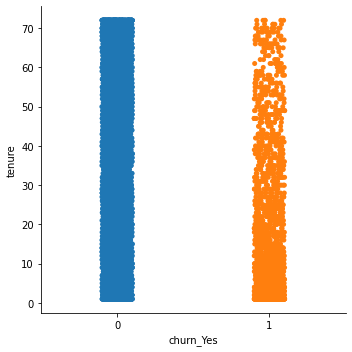

In [55]:
sns.catplot(x='churn_Yes', y='tenure', data=telco_highcorr)


### Exploratory results of looking for drivers of churn by correlation strength:

Largely inconclusive. The variables highest in absolute (+ or -) correlation were not really very strong. 

In [58]:
telco_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 51 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   customer_id                            7032 non-null   object 
 1   gender                                 7032 non-null   object 
 2   senior_citizen                         7032 non-null   int64  
 3   partner                                7032 non-null   object 
 4   dependents                             7032 non-null   object 
 5   tenure                                 7032 non-null   int64  
 6   phone_service                          7032 non-null   object 
 7   multiple_lines                         7032 non-null   object 
 8   internet_service_type_id               7032 non-null   int64  
 9   online_security                        7032 non-null   object 
 10  online_backup                          7032 non-null   object 
 11  devi

### What kind of customer is churning?

In [64]:
churned_customers = telco_df_clean[telco_df_clean.churn_Yes == 1]
churned_customers.mean()


senior_citizen                              0.254682
tenure                                     17.979133
internet_service_type_id                    1.814874
contract_type_id                            1.140182
payment_type_id                             1.813269
monthly_charges                            74.441332
total_charges                            1531.796094
gender_Male                                 0.497592
partner_Yes                                 0.357945
dependents_Yes                              0.174425
phone_service_Yes                           0.909042
multiple_lines_No phone service             0.090958
multiple_lines_Yes                          0.454789
online_security_No internet service         0.060460
online_security_Yes                         0.157838
online_backup_No internet service           0.060460
online_backup_Yes                           0.279829
device_protection_No internet service       0.060460
device_protection_Yes                       0.

In [68]:
print(f'Avg customers with phone service, absolute: {telco_df_clean.phone_service_Yes.mean():.2%}')
print(f'Avg monthly charges of churners with phone service: {churned_customers[churned_customers.phone_service_Yes == 1].monthly_charges.mean()}')
print(f'Avg monthly charges of all churners: {churned_customers.monthly_charges.mean()}')

Avg customers with phone service, absolute: 90.33%
Avg monthly charges of churners with phone service: 78.13425544437897
Avg monthly charges of all churners: 74.44133226324232


In [74]:
churned_customers.rename(columns= {'internet_service_type_Fiber optic': 'fiber_internet', 'internet_service_type_None': 'no_internet'}, inplace=True)
print(f'Overall averages of churners with fiber internet:\n{churned_customers[churned_customers.fiber_internet == 1].mean()}')
print(f'Number of churners who used fiber internet: {churned_customers[churned_customers.fiber_internet == 1].fiber_internet.sum()}')
churned_customers.shape

Overall averages of churners with fiber internet:
senior_citizen                              0.303007
tenure                                     20.196608
internet_service_type_id                    2.000000
contract_type_id                            1.127988
payment_type_id                             1.722436
monthly_charges                            88.126484
total_charges                            1914.616384
gender_Male                                 0.488049
partner_Yes                                 0.387047
dependents_Yes                              0.155744
phone_service_Yes                           1.000000
multiple_lines_No phone service             0.000000
multiple_lines_Yes                          0.591365
online_security_No internet service         0.000000
online_security_Yes                         0.141095
online_backup_No internet service           0.000000
online_backup_Yes                           0.313801
device_protection_No internet service       0.000

(1869, 51)

### Noted trend:
Of customers who churned, nearly 70% had fiber optic internet service. These customers paid almost $15/month more than the average and more than half (52%) streamed TV or movies.

Current hypothesis is that these customers are either dissatified with the service or have found a better price point for the same service with a competitor.